In [28]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
test_unknown_data_path = './data/3_rf_test_unknown_data_v2.csv'
test_unknown_data = pd.read_csv(test_unknown_data_path)

test_unknown_label_path = './data/3_rf_test_unknown_label_v2.csv'
test_unknown_label = pd.read_csv(test_unknown_label_path)

test = './data/testing_data.csv'
test_data = pd.read_csv(test)

test_L= './data/testing_lable.csv'
test_L_data  = pd.read_csv(test_L)

In [30]:
import pickle

In [31]:
with open('./data/5_gan_data_v1_1.pkl', 'rb') as file:
    gan_data_v1 = pickle.load(file)
with open('./data/5_gan_label_v1_1.pkl', 'rb') as file:
    gan_label_v1 = pickle.load(file)
with open('./data/5_gan_data_v1_2.pkl', 'rb') as file:
    gan_data_v1a = pickle.load(file)
with open('./data/5_gan_label_v1_2.pkl', 'rb') as file:
    gan_label_v1a = pickle.load(file)

In [32]:
with open('./data/5_gan_data_v2_1.pkl', 'rb') as file:
    gan_data_v2 = pickle.load(file)
with open('./data/5_gan_label_v2_1.pkl', 'rb') as file:
    gan_label_v2 = pickle.load(file)
with open('./data/5_gan_data_v2_2.pkl', 'rb') as file:
    gan_data_v2a = pickle.load(file)
with open('./data/5_gan_label_v2_2.pkl', 'rb') as file:
    gan_label_v2a = pickle.load(file)

In [33]:
with open('./data/class_mapping.pkl', 'rb') as file:
    class_mapping = pickle.load(file)

In [34]:
class_mapping

{'Backdoor_Malware': 0,
 'BenignTraffic': 1,
 'BrowserHijacking': 2,
 'CommandInjection': 3,
 'DDoS-ACK_Fragmentation': 4,
 'DDoS-HTTP_Flood': 5,
 'DDoS-ICMP_Flood': 6,
 'DDoS-ICMP_Fragmentation': 7,
 'DDoS-PSHACK_Flood': 8,
 'DDoS-RSTFINFlood': 9,
 'DDoS-SYN_Flood': 10,
 'DDoS-SlowLoris': 11,
 'DDoS-SynonymousIP_Flood': 12,
 'DDoS-TCP_Flood': 13,
 'DDoS-UDP_Flood': 14,
 'DDoS-UDP_Fragmentation': 15,
 'DNS_Spoofing': 16,
 'DictionaryBruteForce': 17,
 'DoS-HTTP_Flood': 18,
 'DoS-SYN_Flood': 19,
 'DoS-TCP_Flood': 20,
 'DoS-UDP_Flood': 21,
 'MITM-ArpSpoofing': 22,
 'Mirai-greeth_flood': 23,
 'Mirai-greip_flood': 24,
 'Mirai-udpplain': 25,
 'Recon-HostDiscovery': 26,
 'Recon-OSScan': 27,
 'Recon-PingSweep': 28,
 'Recon-PortScan': 29,
 'SqlInjection': 30,
 'Uploading_Attack': 31,
 'VulnerabilityScan': 32,
 'XSS': 33}

In [35]:
# flip the dictionary. key into value, and vice versa
flipped_dict = dict((v, k) for k, v in class_mapping.items())

In [36]:
gan_label_v1 = pd.DataFrame(gan_label_v1)
gan_label_v2 = pd.DataFrame(gan_label_v2)
gan_label_v1a = pd.DataFrame(gan_label_v1)
gan_label_v2a = pd.DataFrame(gan_label_v2)

In [37]:
gan_label_v1

,label
0,1
1,1
2,1
3,1
4,1
...,...
16872,8
16873,7
16874,7
16875,4


In [38]:
gan_label_v1['label'] = gan_label_v1['label'].replace(flipped_dict)
gan_label_v2['label'] = gan_label_v2['label'].replace(flipped_dict)
gan_label_v1a['label'] = gan_label_v1a['label'].replace(flipped_dict)
gan_label_v2a['label'] = gan_label_v2a['label'].replace(flipped_dict)

In [39]:
gan_label_v1['label'].value_counts()
gan_label_v1a['label'].value_counts()

label
BenignTraffic              15119
DDoS-PSHACK_Flood            768
DDoS-ICMP_Fragmentation      515
DDoS-ACK_Fragmentation       348
DDoS-HTTP_Flood               52
DDoS-RSTFINFlood              39
BrowserHijacking              12
CommandInjection               7
Backdoor_Malware               6
DDoS-SlowLoris                 6
DDoS-ICMP_Flood                5
Name: count, dtype: int64

In [40]:
attacks = ['DDoS', 'DoS', 'Mirai', 'Recon']

def mergeAttacks(dataframe, attacks):
    """ Merge attacks into big category

    Args:
        dataframe(Pandas dataframe): Contains specific attacks

    Return:
        (Pandas dataframe): merged dataframe
    """

    dataframe.loc[dataframe['label'].str.contains('DDoS'), 'label'] = 'andrew-nah'

    for attack in attacks:
        if attack == 'DDoS':
            continue
        dataframe.loc[dataframe['label'].str.contains(attack), 'label'] = attack
    
    dataframe.loc[dataframe['label'].str.contains('andrew-nah'), 'label'] = 'DDoS'
    
    return dataframe

# Merge attacks in syntesized data

In [41]:
gan_label_v1 = mergeAttacks(gan_label_v1, attacks)
gan_label_v2 = mergeAttacks(gan_label_v2, attacks)
gan_label_v1a = mergeAttacks(gan_label_v1a, attacks)
gan_label_v2a = mergeAttacks(gan_label_v2a, attacks)

# Drop the major attacks; DDoS, DoS, Mirai

In [42]:
def dropMajor(data, label):
    """ Drop the designated attacks

    Args:
        data(Pandas dataframe): data without labels
        label(Pandas dataframe): corresponding labels to data

    Return:
        (Pandas dataframe): dataframe without designated attacks

    """
    df = pd.concat([data, label], axis=1)
    df_filtered = df.drop(df[df['label'].isin(['BenignTraffic'])].index)
    return df_filtered


In [43]:
gan_dropped_v1 = dropMajor(gan_data_v1, gan_label_v1)
gan_dropped_v2 = dropMajor(gan_data_v2, gan_label_v2)
gan_dropped_v1a = dropMajor(gan_data_v1a, gan_label_v1a)
gan_dropped_v2a = dropMajor(gan_data_v2a, gan_label_v2a)

In [44]:
gan_dropped_v1['label'].value_counts()
gan_dropped_v1a['label'].value_counts()

label
DDoS                1733
BrowserHijacking      12
CommandInjection       7
Backdoor_Malware       6
Name: count, dtype: int64

In [45]:
gan_dropped_v2['label'].value_counts()
gan_dropped_v2a['label'].value_counts()

label
DDoS                593
BrowserHijacking      4
CommandInjection      4
Backdoor_Malware      2
Name: count, dtype: int64

In [46]:
gan_dropped_data_v1 = gan_dropped_v1.drop(columns=['label'])
gan_dropped_label_v1 = pd.DataFrame(gan_dropped_v1['label'])
gan_dropped_data_v2 = gan_dropped_v2.drop(columns=['label'])
gan_dropped_label_v2 = pd.DataFrame(gan_dropped_v2['label'])
gan_dropped_data_v1a = gan_dropped_v1a.drop(columns=['label'])
gan_dropped_label_v1a = pd.DataFrame(gan_dropped_v1a['label'])
gan_dropped_data_v2a = gan_dropped_v2a.drop(columns=['label'])
gan_dropped_label_v2a = pd.DataFrame(gan_dropped_v2a['label'])

# Merge original and synthesized data together

In [47]:
gan_merged_data = pd.concat([gan_dropped_data_v1,gan_dropped_data_v2], axis=0)
gan_merged_label = pd.concat([gan_dropped_label_v1, gan_dropped_label_v2], axis=0)
gan_merged_data2 = pd.concat([gan_dropped_data_v1a,gan_dropped_data_v2a], axis=0)
gan_merged_label2 = pd.concat([gan_dropped_label_v1a, gan_dropped_label_v2a], axis=0)
gan_data = pd.concat([gan_merged_data,gan_merged_data2], axis=0)
gan_label = pd.concat([gan_merged_label, gan_merged_label2], axis=0)
train_data = pd.concat([gan_data,test_unknown_data], axis=0)
train_label = pd.concat([gan_label, test_unknown_label], axis=0)

In [48]:
train_label.value_counts()

label               
BenignTraffic           5062
DDoS                    4652
Recon                    258
MITM-ArpSpoofing         191
DNS_Spoofing             135
BrowserHijacking          36
CommandInjection          25
DictionaryBruteForce      21
Backdoor_Malware          19
SqlInjection              11
XSS                        2
VulnerabilityScan          1
Name: count, dtype: int64

In [49]:
# Display column names
print("Column names:")
print(train_data.columns)

# Display dataset shape
print("\nDataset shape:")
print(train_data.shape)


Column names:
Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight'],
      dtype='object')

Dataset shape:
(10416, 46)


In [50]:
# Print data types
print("\nData Types:")
print(train_data.dtypes)


Data Types:
flow_duration      float64
Header_Length      float64
Protocol Type      float64
Duration           float64
Rate               float64
Srate              float64
Drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IPv                float64
LLC                float64
Tot sum            float64
Min                float64
Max                float64
AVG            

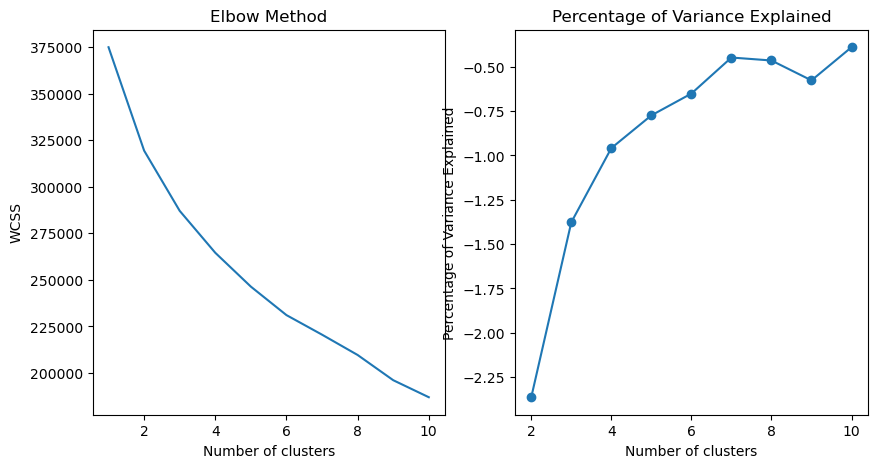

In [51]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming 'test_unknown_data' is your dataset
data = train_data

# Step 4: Data Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Step 5: Choose the Number of Clusters (K)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Calculate the percentage of variance explained
percentage_var_explained = np.diff(wcss) / np.sum(wcss[:-1]) * 100

# Plotting the elbow graph with the percentage of variance explained
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), percentage_var_explained, marker='o')
plt.title('Percentage of Variance Explained')
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of Variance Explained')
plt.show()


Silhouette Score: 0.20836552851046508


C:\Users\aravi\AppData\Local\Temp\ipykernel_44332\2335598788.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(range(len(test_cluster_labels)), test_cluster_labels, cmap='viridis', marker='o')


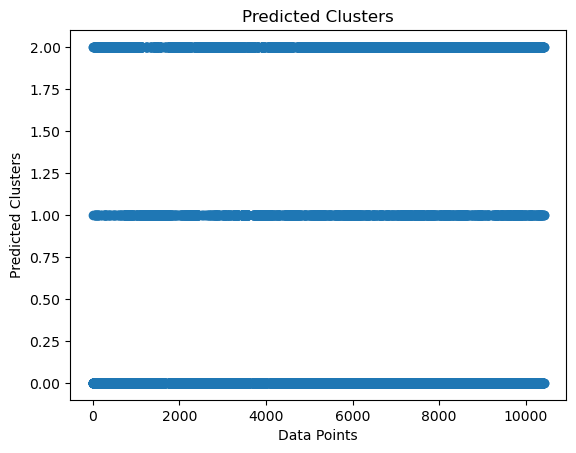

In [52]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Drop the 'Cluster' column if it exists
data_for_scaling = data.drop('Cluster', axis=1, errors='ignore')

# Step 4: Data Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_scaling)

# Manually set the optimal number of clusters based on the elbow method
your_optimal_k = 3

# Fit K-Means model to the training data
kmeans = KMeans(n_clusters=your_optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=2)
kmeans.fit(scaled_data)

# Assuming your test data has the same features as the training data
scaled_test_data = scaler.transform(data_for_scaling)

# Predict the clusters for the test data
test_cluster_labels = kmeans.predict(scaled_test_data)

# Silhouette Score for clustering evaluation
silhouette_avg = silhouette_score(scaled_test_data, test_cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Plotting predicted clusters
plt.scatter(range(len(test_cluster_labels)), test_cluster_labels, cmap='viridis', marker='o')
plt.xlabel('Data Points')
plt.ylabel('Predicted Clusters')
plt.title('Predicted Clusters')
plt.show()


c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


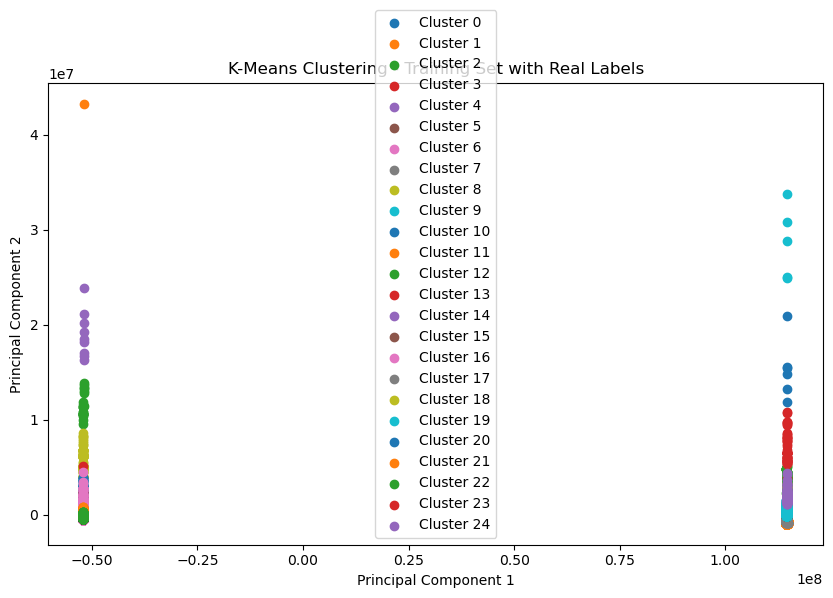

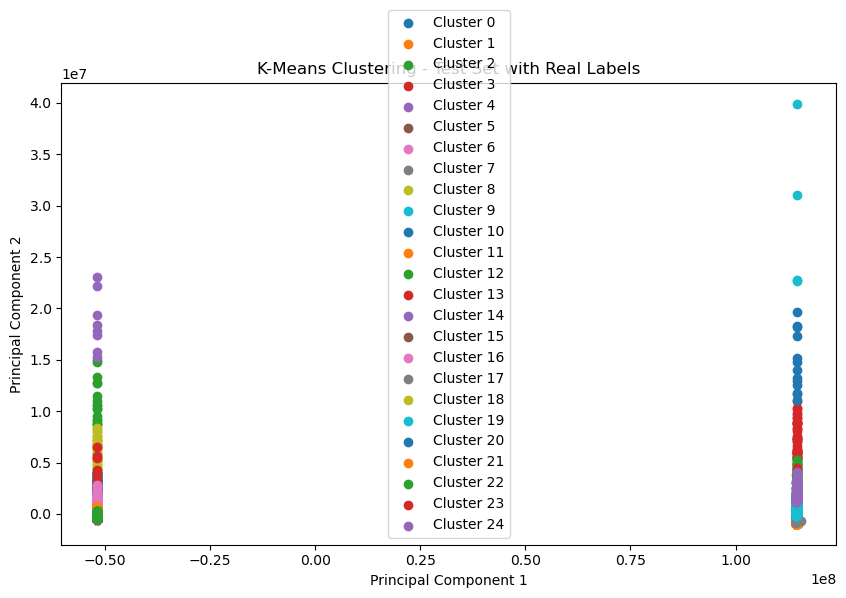

In [53]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import numpy as np


X = train_data
y = train_label['label'] 

# Apply label encoding to the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train = X
y_train = y

X_test = test_data
y_test = test_L_data

# Specify the number of clusters
number_of_clusters = 25

# Apply k-means clustering on the training set
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
train_predicted_labels = kmeans.fit_predict(X_train)

# Apply the clustering model to the test set
test_predicted_labels = kmeans.predict(X_test)

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Scatter plot for training set with real labels
plt.figure(figsize=(10, 6))
for cluster in range(number_of_clusters):
    cluster_mask = (train_predicted_labels == cluster)
    plt.scatter(X_train_reduced[cluster_mask, 0], X_train_reduced[cluster_mask, 1], label=f'Cluster {cluster}')

plt.title('K-Means Clustering - Training Set with Real Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Scatter plot for test set with real labels
plt.figure(figsize=(10, 6))
for cluster in range(number_of_clusters):
    cluster_mask = (test_predicted_labels == cluster)
    plt.scatter(X_test_reduced[cluster_mask, 0], X_test_reduced[cluster_mask, 1], label=f'Cluster {cluster}')

plt.title('K-Means Clustering - Test Set with Real Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


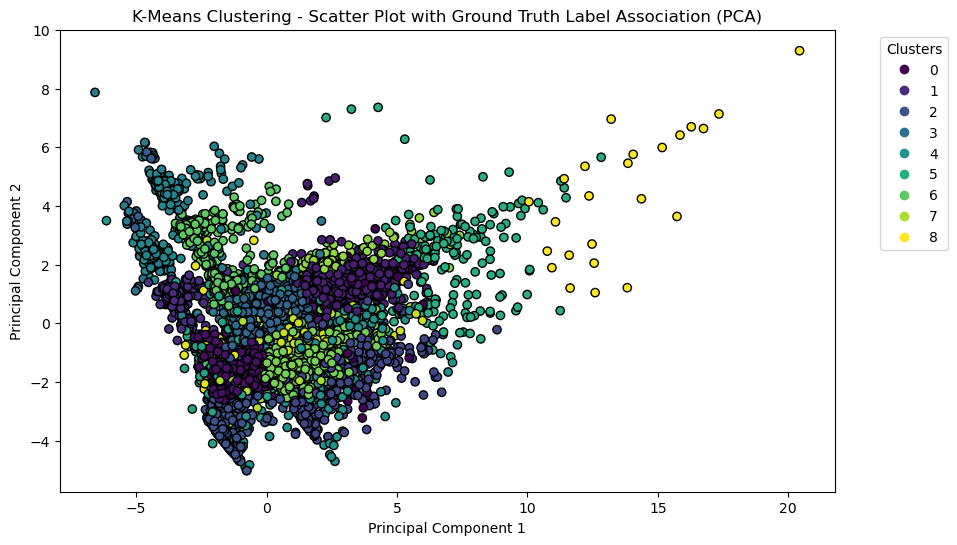

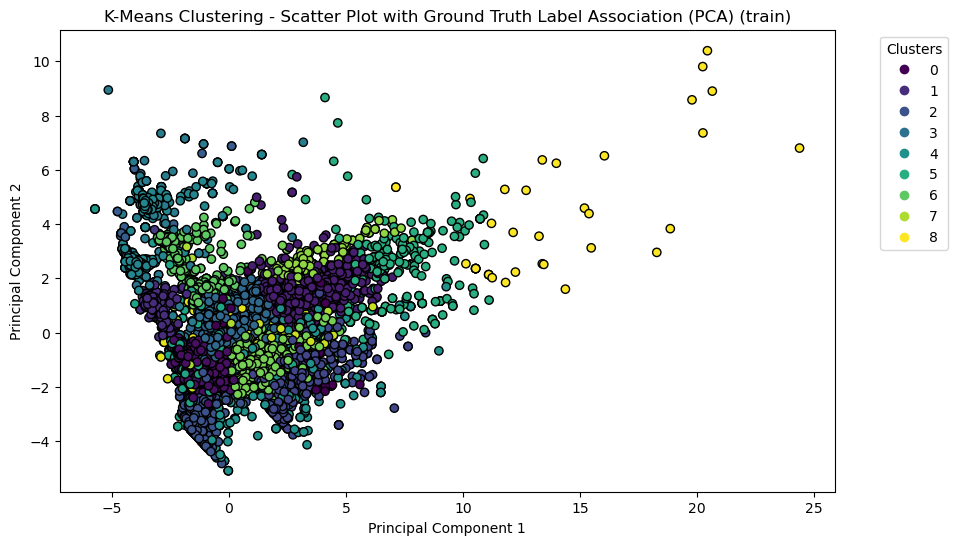

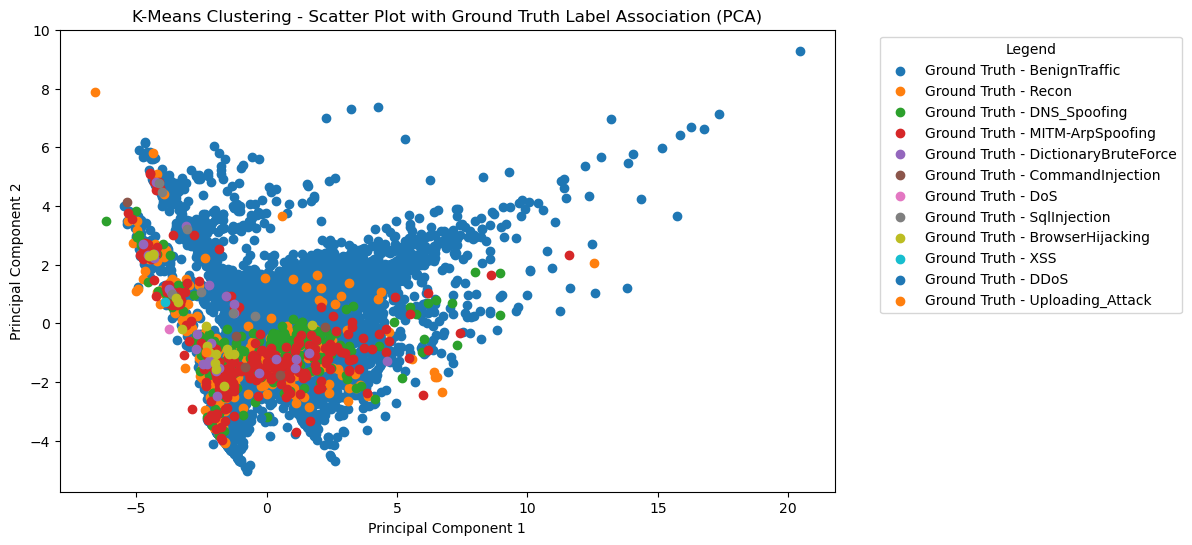

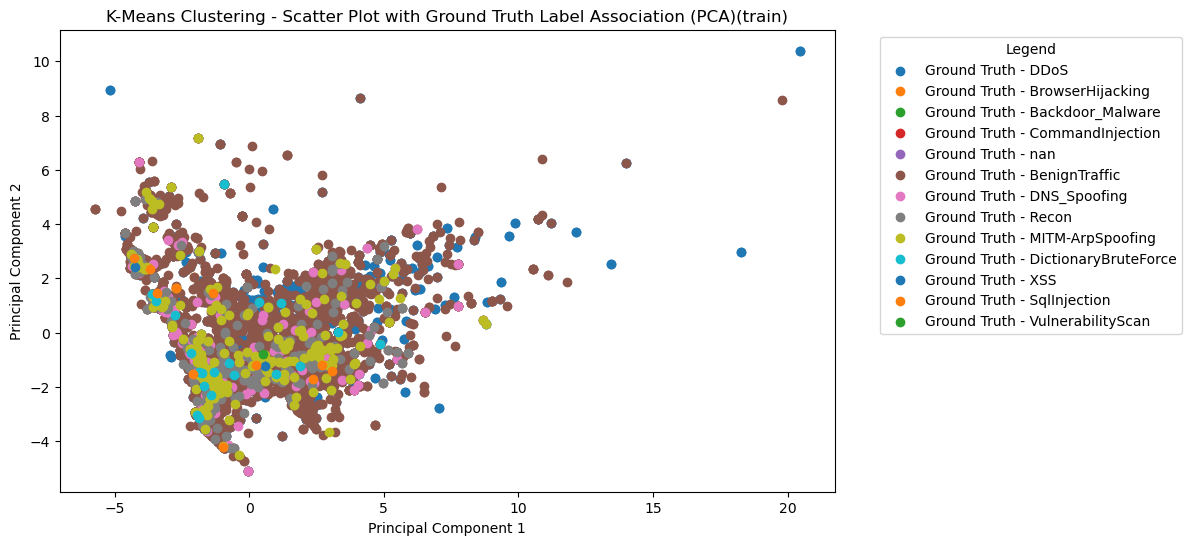

In [54]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

X = X_test
y_true = y_test['label']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_train = scaler.fit_transform(X_train)

# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca_train = pca.fit_transform(X_scaled_train)

# Apply k-means clustering on the reduced dataset

# MAIN CHANGE!!
number_of_clusters = 25
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
predicted_labels_train_data = kmeans.fit(X_scaled_train)
predicted_labels_train = kmeans.predict(X_scaled_train)
predicted_labels = kmeans.predict(X_scaled)

# Create a DataFrame to store the association between clusters and ground truth labels
cluster_label_association = pd.DataFrame({'Cluster': predicted_labels, 'Ground Truth Label': y_true})
cluster_label_association_train = pd.DataFrame({'Cluster': predicted_labels_train, 'Ground Truth Label': y})

# Plot the association using a scatter plot
plt.figure(figsize=(10, 6))

# Plot data points without label names
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis', marker='o', edgecolors='k', label='Clustered Data')

# Create a legend with cluster numbers
legend_labels = list(range(number_of_clusters))
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

# Plot the association using a scatter plot
plt.figure(figsize=(10, 6))

# Plot data points without label names
scatter = plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=predicted_labels_train, cmap='viridis', marker='o', edgecolors='k', label='Clustered Data')

# Create a legend with cluster numbers
legend_labels = list(range(number_of_clusters))
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA) (train)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

# Plot the association using a scatter plot
plt.figure(figsize=(10, 6))

# Iterate over unique ground truth labels
for label in y_true.unique():
    indices = cluster_label_association[cluster_label_association['Ground Truth Label'] == label].index
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=f'Ground Truth - {label}')

# Add legend
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

# Plot the association using a scatter plot
plt.figure(figsize=(10, 6))

# Iterate over unique ground truth labels
for label in y_train.unique():
    indices = cluster_label_association_train[cluster_label_association_train['Ground Truth Label'] == label].index
    indices = indices[indices < len(X_pca_train)] 
    plt.scatter(X_pca_train[indices, 0], X_pca_train[indices, 1], label=f'Ground Truth - {label}')

# Add legend
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA)(train)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

In [55]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Assuming 'test_unknown_label' is your true labels
y_true = y_test['label']

# Define the positive class
positive_class = 'BenignTraffic'

# Create binary labels for the positive class
y_binary = (y_true == positive_class).astype(int)

# Evaluate K-means performance using confusion matrix
conf_matrix = confusion_matrix(y_binary, predicted_labels)

# Extract unique class labels (excluding the positive class)
unique_labels = pd.Series(y_true.unique()).loc[lambda x: x != positive_class].tolist()

# Calculate False Positives and True Negatives for the positive class against every other class
false_positives = {}
true_negatives = {}
for i, label in enumerate(unique_labels, start=0):
    false_positives[label] = conf_matrix[i, 0]
    true_negatives[label] = conf_matrix[0, i + 1:].sum() + conf_matrix[i + 1:, i + 1:].sum()

# Calculate False Positive Rate for the positive class against every other class
fpr = {}
for label in unique_labels:
    denominator = false_positives[label] + true_negatives[label]
    # Handle the case where both False Positives and True Negatives are zero
    fpr[label] = false_positives[label] / denominator if denominator != 0 else 0

print(f"False Positive Rate for class '{positive_class}' against every other class:")
for label, fpr_value in fpr.items():
    print(f"Class '{label}': {fpr_value}")


False Positive Rate for class 'BenignTraffic' against every other class:
Class 'Recon': 0.004849522179432321
Class 'DNS_Spoofing': 0.14133333333333334
Class 'MITM-ArpSpoofing': 0.0
Class 'DictionaryBruteForce': 0.0
Class 'CommandInjection': 0.0
Class 'DoS': 0.0
Class 'SqlInjection': 0.0
Class 'BrowserHijacking': 0.0
Class 'XSS': 0.0
Class 'DDoS': 0.0
Class 'Uploading_Attack': 0.0


In [56]:
cluster_label_association

,Cluster,Ground Truth Label
0,18,BenignTraffic
1,14,Recon
2,5,BenignTraffic
3,1,BenignTraffic
4,1,BenignTraffic
...,...,...
7112,18,BenignTraffic
7113,8,BenignTraffic
7114,6,BenignTraffic
7115,1,BenignTraffic


In [57]:
cluster_gtl_counts = cluster_label_association.groupby('Cluster')['Ground Truth Label'].value_counts().unstack(fill_value=0)

In [58]:
cluster_gtl_counts_train = cluster_label_association_train.groupby('Cluster')['Ground Truth Label'].value_counts().unstack(fill_value=0)

In [59]:
print(cluster_gtl_counts)
print(cluster_gtl_counts_train)

Ground Truth Label  BenignTraffic  BrowserHijacking  CommandInjection  DDoS  \
Cluster                                                                       
0                             106                 2                 0     0   
1                             819                 6                 1     0   
2                             833                 0                 0     0   
3                             217                 4                 1     0   
4                               1                 0                 0     0   
5                             378                 1                 0     0   
6                             401                 0                 0     0   
7                               9                 0                 1     0   
8                             989                 0                 0     0   
9                               1                 0                 0     0   
10                             65                 0 

In [60]:
cluster_b_ratio = (cluster_gtl_counts['BenignTraffic'] / cluster_gtl_counts.sum(axis=1)).fillna(0)

print(cluster_b_ratio)
cluster_b_ratio_train = (cluster_gtl_counts_train['BenignTraffic'] / cluster_gtl_counts_train.sum(axis=1)).fillna(0)

print("Training result - ", cluster_b_ratio_train)

Cluster
0     0.757143
1     0.785988
2     0.989311
3     0.653614
4     0.200000
5     0.881119
6     0.889135
7     0.600000
8     0.994970
9     0.250000
10    0.928571
11    0.808190
12    0.996047
13    0.000000
14    0.755102
15    0.930636
17    0.000000
18    0.989754
19    0.816716
20    1.000000
21    0.901099
22    0.598684
23    0.725490
24    0.920000
dtype: float64
Training result -  Cluster
0     0.264463
1     0.349267
2     0.907473
3     0.232915
4     0.272727
5     0.405446
6     0.481224
7     0.416667
8     0.891637
9     0.500000
10    0.340909
11    0.370460
12    0.750820
13    0.000000
14    0.321063
15    0.691983
16    0.000000
17    0.000000
18    0.730693
19    0.426690
20    0.495238
21    0.303571
22    0.173295
23    0.493506
24    0.756757
dtype: float64
